<a href="https://colab.research.google.com/github/NicoleRichards1998/FinRL/blob/master/Copy_of_DayTrading_FinRL_JSE_Singe_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: Nothing herein is financial advice, and NOT a recommendation to trade real money. Many platforms exist for simulated trading (paper trading) which can be used for building and developing the methods discussed. Please use common sense and always first consult a professional before trading or investing.

# Part 1: Install FinRL

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [ ]:
!pip install tensorboardX

In [ ]:
!pip uninstall -y pyarrow
!pip uninstall -y ray # clean removal of previous install, otherwise version number may cause pip not to upgrade

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!pip install tf-estimator-nightly==2.8.0.dev2021122109
!pip install -U https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-2.0.0.dev0-cp37-cp37m-manylinux2014_x86_64.whl # minimal install
!pip install lz4

In [1]:
!pip install git+https://github.com/NicoleRichards1998/FinRL.git

  Cloning https://github.com/NicoleRichards1998/FinRL.git to /tmp/pip-req-build-nzd0ygc7
  Running command git clone -q https://github.com/NicoleRichards1998/FinRL.git /tmp/pip-req-build-nzd0ygc7
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-_1jk_r6b/pyfolio_509482a0aabf443a8a96fce7c2291708
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-_1jk_r6b/pyfolio_509482a0aabf443a8a96fce7c2291708
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-_1jk_r6b/elegantrl_c1533fa287e64bd7befd3ffd8e1b8346
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-_1jk_r6b/elegantrl_c1533fa287e64bd7befd3ffd8e1b8346
     |████████████████████████████████| 234 kB 18.6 MB/s 
     |████████████████████████████████| 177 kB 49.2 MB/s 
     |████████████████████████████████| 53.2 MB 235 kB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████

In [ ]:
print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment


## Import related modules

In [1]:
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import DayTradingEnv as StockTradingEnv1
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_np import ChangedStockTradingEnv as StockTradingEnv2
from finrl.finrl_meta.env_stock_trading.env_stock_papertrading import AlpacaPaperTrading
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.rllib.models import DRLAgent as DRLAgent_rllib

import numpy as np
import pandas as pd
import ray

from ray.rllib.agents.a3c import a2c
from ray.rllib.agents.ddpg import ddpg, td3
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.sac import sac
from ray.tune.logger import (
    CSVLoggerCallback,
    JsonLoggerCallback,
    JsonLogger,
    CSVLogger,
    TBXLoggerCallback,
    TBXLogger,
    UnifiedLogger
)
from ray.tune.logger import pretty_print

from google.colab import files
from datetime import date, timedelta, datetime

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.core.arrays import string_

import pytz
import exchange_calendars as tc

from stockstats import StockDataFrame as Sdf

import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Set variables

In [2]:
model_algorithm = 'ppo'
starting_capital = 1e6

Number_Train_Days = 10

Number_Test_Days = 9

In [3]:
JSEIndexes = [ 'ACL' ]

In [ ]:
JSEIndexes = [ 
  'SNH',
  'WHL',
 'FSR',
 'RMH',
 'BLU',
 'SSW',
 'LAB',
 'TGA',
 'SPG',
 'PPC',
 'OMU',
 'GFI',
 'NPK',
 'HAR',
 'LHC',
 'TSG',
 'ACL',
 'PPH',
 'SBK',
 'PPE',
 'CML',
 'MRF',
 'MTN',
 'AVI',
 'SOL',
 'EXX',
 'TRU',
 'NED',
 'TCP',
 'WSL'
 ]

In [4]:
ticker_list = JSEIndexes
action_dim = len(ticker_list)

INDICATORS = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'dx_30', 'close_30_sma', 'close_60_sma']
tech_indicator_list = INDICATORS
env = StockTradingEnv2

# amount + (turbulence, turbulence_bool) + (price, shares, cd (holding time)) * stock_dim + tech_dim
state_dim = 1 + 2 + 3 * action_dim + len(INDICATORS) * action_dim

episodes_per_day = 200
tr_batch_size = episodes_per_day*480

rllib_params = {"lr": 5e-5, "train_batch_size": tr_batch_size, "gamma": 0.99}

MODELS = {"a2c": a2c, "ddpg": ddpg, "td3": td3, "sac": sac, "ppo": ppo}

In [ ]:
action_dim

1

# Part 2: Train the agent

## Train

In [5]:
%load_ext tensorboard

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/csvfiles/

/content/drive/MyDrive/csvfiles


In [7]:
data_df = pd.read_csv("JSE_Minute_Data_With_Turbulance_Indicator.csv")

In [8]:
df = data_df.copy()
df = df.sort_values(by=["tic", "date"])
x = 9620
dic_tickers = {}

for i in range(30):

  dic_tickers[i] = df.iloc[(i*x):((i+1)*x),]

In [ ]:
dic_tickers[0]

In [9]:
trading_days = pd.date_range(start = '02/28/22', end = '03/25/22')

trading_days_List = trading_days[0:].strftime('%m/%d/%y').to_numpy().tolist()
count = 0
delete_number = 0
while count < 26:
    if (trading_days[count].weekday()>=5):
      del trading_days_List[delete_number]
      delete_number = delete_number - 1
    count = count + 1
    delete_number = delete_number + 1 

In [ ]:
df = dic_tickers[0].copy()
df

In [10]:
x = 481
df = dic_tickers[0].copy()
df = df.reset_index(drop=True)
dic = {}

for j in range(len(df)):
    df['date'][j] = datetime.strptime(df['date'][j], '%m/%d/%y %H:%M')
df = df.sort_values(by=["date"])

for i in range(20):
  
  dic[i] = df.iloc[(i*x):((i+1)*x),]
  dic[i] = dic[i].sort_values(by=["tic", "date"])
  dic[i] = dic[i].reset_index(drop=True)
  #for j in range(len(dic[i])):
  #  dic[i]['date'][j] = datetime.strptime(dic[i]['date'][j], '%m/%d/%y %H:%M')
  dic[i] = dic[i].sort_values(by=["date"])

del dic[15]
dic = dict(enumerate(dic[x] for x in sorted(dic)))

In [ ]:
dic[18]

In [ ]:
x = 14430
df = data_df.copy()
dic = {}

for i in range(20):

  dic[i] = df.iloc[(i*x):((i+1)*x),]


In [11]:
def df_to_array(df, if_vix):
        df = df.copy()
        unique_ticker = df.tic.unique()
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic == tic][["close"]].values
                tech_array = df[df.tic == tic][tech_indicator_list].values
                if if_vix:
                    turbulence_array = df[df.tic == tic]["VIXY"].values
                else:
                    turbulence_array = df[df.tic == tic]["turbulence"].values
                if_first_time = False
            else:
                price_array = np.hstack(
                    [price_array, df[df.tic == tic][["close"]].values]
                )
                tech_array = np.hstack(
                    [tech_array, df[df.tic == tic][tech_indicator_list].values]
                )
        print("Successfully transformed into array")
        return price_array, tech_array, turbulence_array

In [12]:
def get_config_Train(dic, Number_Days):  

    env_config = []

    for index in range(Number_Days):

      print(index)

      price_array, tech_array, turbulence_array = df_to_array(dic[index], False)

      config = {
          "price_array": price_array,
          "tech_array": tech_array,
          "turbulence_array": turbulence_array,
          "if_train": True,
      }

      env_config.append(config)

    return env_config

In [13]:
train_env_config = get_config_Train(dic, Number_Train_Days)

0
Successfully transformed into array
1
Successfully transformed into array
2
Successfully transformed into array
3
Successfully transformed into array
4
Successfully transformed into array
5
Successfully transformed into array
6
Successfully transformed into array
7
Successfully transformed into array
8
Successfully transformed into array
9
Successfully transformed into array


In [14]:
from typing import Dict

import json

import os
import tempfile

from ray.tune.utils.util import SafeFallbackEncoder
from ray.tune.logger import Logger

EXPR_TRACK_FILE = "episode_tracking.json"
CUSTOM_RESULTS_DIR = '/content/drive/MyDrive/TrainingData'
DEFAULT_LOGGERS = (JsonLogger, CSVLogger, TBXLogger)

class CustomLogger(Logger):
    """Logs custom results in json format."""

    def _init(self):
        self.update_config(self.config)
        logger_config = self.config.get("logger_config")
        filename = EXPR_TRACK_FILE
        if logger_config:
            filename = logger_config.get("filename") or filename
        local_file = os.path.join(self.logdir, filename)
        self.local_out = open(local_file, "a")

    def on_result(self, result: Dict):
        tracking_data = result["episode_media"]
        if not tracking_data:
            return
        json.dump(tracking_data, self, cls=SafeFallbackEncoder)
        self.write("\n")
        self.local_out.flush()

    def write(self, b):
        self.local_out.write(b)

    def flush(self):
        if not self.local_out.closed:
            self.local_out.flush()

    def close(self):
        self.local_out.close()

    def update_config(self, config: Dict):
        self.config = config

def custom_logger_creator(config):
    """Creates a Unified logger with a default logdir prefix
    containing the agent name and the env id
    """
    timestr = datetime.today().strftime("%Y-%m-%d_%H-%M-%S")
    logdir_prefix = "{}_{}_{}".format("PPO", "HSP", timestr)
    if not os.path.exists(CUSTOM_RESULTS_DIR):
        os.makedirs(CUSTOM_RESULTS_DIR)
    logdir = tempfile.mkdtemp(
        prefix=logdir_prefix, dir=CUSTOM_RESULTS_DIR)
    loggers = list(DEFAULT_LOGGERS)
    loggers.append(CustomLogger)
    return UnifiedLogger(config, logdir, loggers=loggers)

In [15]:
def training(
        env_config,
        drl_lib,
        env,
        model_name,
        init_ray=True,
        **kwargs
):
   
    env_instance = env(config=env_config)

    print(env_instance)

    rllib_params = kwargs.get("rllib_params")
    
    agent_rllib = DRLAgent_rllib(
            env=env,
            price_array=env_config['price_array'],
            tech_array=env_config['tech_array'],
            turbulence_array=env_config['turbulence_array'],
        )
    
    print(agent_rllib)

    model, model_config = agent_rllib.get_model(model_name)

    print('got model_config')

    model_config["lr"] = rllib_params["lr"]
    model_config["train_batch_size"] = rllib_params["train_batch_size"]
    model_config["gamma"] = rllib_params["gamma"]

    #model_config["output"] = "/content/drive/MyDrive/csvfiles" 
    #model_config["local_dir"] = "./trained_models"
    #model_config["reuse_actors"] = True
    #model_config["callbacks"] = [TBXLoggerCallback()]

    model_config['framework'] = "tf2"

    model_config["model"]["use_lstm"] = True
    model_config["model"]["lstm_cell_size"] = 256
    model_config["model"]["lstm_use_prev_action"] = True
    model_config["model"]["lstm_use_prev_reward"] = True

    if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
    if init_ray:
            ray.init(
                ignore_reinit_error=True
            )  # Other Ray APIs will not work until `ray.init()` is called.
    print('ray initialised')

    if model_name == "ppo":
            trainer = model.PPOTrainer(env=env, logger_creator=custom_logger_creator, config=model_config)
    elif model_name == "a2c":
            trainer = model.A2CTrainer(env=env, config=model_config)
    elif model_name == "ddpg":
            trainer = model.DDPGTrainer(env=env, config=model_config)
    elif model_name == "td3":
            trainer = model.TD3Trainer(env=env, config=model_config)
    elif model_name == "sac":
            trainer = model.SACTrainer(env=env, config=model_config)

    print('got trainer')
    return(trainer)

In [16]:
def train_model(
        total_episodes,
        env_config_list,
        drl_lib,
        env,
        model_name,
        init_ray=True,
        **kwargs
):

        s = "{:3d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:6.2f} saved {}"

        trainer = training(
                        env_config = env_config_list[0],
                        drl_lib='rllib', 
                        env=env,
                        model_name = model_algorithm, 
                        init_ray=True,
                        rllib_params = rllib_params,
                        local_dir="./trained_models",#Saving tensorboard plots
                        reuse_actors=True,
                        callbacks=[TBXLoggerCallback()]
                        #callbacks = {#"on_episode_start": on_episode_start,
                                    #"on_episode_step": on_episode_step,
                                    #"on_episode_end": on_episode_end,
                                    #"on_sample_end": on_sample_end,
                                    #"on_postprocess_traj": on_postprocess_traj,
                                    #"on_train_result": on_train_result,
                                    #},
                                    )
        #trainer.restore('/tmp/rllib_checkpoint/checkpoint_000020/checkpoint-20')
        result = trainer.train()
        print(pretty_print(result))
            
        file_name = trainer.save("/tmp/rllib_checkpoint")

        print(s.format(
              1,
              result["episode_reward_min"],
              result["episode_reward_mean"],
              result["episode_reward_max"],
              result["episode_len_mean"],
              file_name
            ))

        ray.shutdown()

        for episode in range(total_episodes-1):
            trainer = training(
                        env_config = env_config_list[episode+1],
                        drl_lib='rllib',
                        env=env,
                        model_name = model_algorithm, 
                        init_ray=True,
                        rllib_params = rllib_params,
                        local_dir="./trained_models",#Saving tensorboard plots
                        reuse_actors=True,
                        callbacks=[TBXLoggerCallback()])
                        
            trainer.restore(file_name)
            result = trainer.train()
            print(pretty_print(result))
            
            file_name = trainer.save("/tmp/rllib_checkpoint")

            print(s.format(
              episode + 2,
              result["episode_reward_min"],
              result["episode_reward_mean"],
              result["episode_reward_max"],
              result["episode_len_mean"],
              file_name
            ))

            ray.shutdown()
  
        return file_name

In [27]:
ray.shutdown()

In [17]:
checkpoint_path = train_model(
      total_episodes = len(train_env_config),
      env_config_list = train_env_config,
      drl_lib='rllib', 
      env=env,
      model_name = model_algorithm, 
      rllib_params = rllib_params)

<ChangedStockTradingEnv instance>
got model_config


2022-05-17 07:01:29,312	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
2022-05-17 07:01:31,045	INFO trainer.py:2296 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-05-17 07:01:31,053	INFO ppo.py:269 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-05-17 07:01:31,053	INFO trainer.py:867 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


ray initialised


(RolloutWorker pid=874) 2022-05-17 07:01:37,770	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=874) 2022-05-17 07:01:37,770	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=873) 2022-05-17 07:01:37,762	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly.

2022-05-17 07:02:00,414	INFO trainable.py:156 -- Trainable.setup took 29.371 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 07:04:23,925	WARNING deprecation.py:47 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


agent_timesteps_total: 96000
custom_metrics: {}
date: 2022-05-17_07-16-21
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 11.297214549537653
episode_reward_mean: -6.9319346593229065
episode_reward_min: -18.70328402924723
episodes_this_iter: 200
episodes_total: 200
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 2.1062073707580566
        entropy_coeff: 0.0
        kl: 0.003432851517572999
        model: {}
        policy_loss: -0.0006356114172376692
        total_loss: 1.263641119003296
        vf_explained_var: -0.0009097503498196602
        vf_loss: 1.2635903358459473
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 96000
  num_agent_steps_trained: 96000
  num_steps_sampled: 96000
  num_steps_trained: 96000
  num_steps_trained_this_iter: 96000


2022-05-17 07:16:27,028	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=2607) 2022-05-17 07:16:37,704	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=2607) 2022-05-17 07:16:37,704	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=2609) 2022-05-17 07:16:37,614	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrect

2022-05-17 07:16:43,785	INFO trainable.py:156 -- Trainable.setup took 13.715 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 07:16:44,152	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000001/checkpoint-1
2022-05-17 07:16:44,157	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': 96000, '_time_total': 861.281779050827, '_episodes_total': 200}


agent_timesteps_total: 192000
custom_metrics: {}
date: 2022-05-17_07-33-13
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 19.587918270040976
episode_reward_mean: -7.958437540445765
episode_reward_min: -24.56849988120745
episodes_this_iter: 200
episodes_total: 400
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.10000000149011612
        cur_lr: 4.999999873689376e-05
        entropy: 2.018433094024658
        entropy_coeff: 0.0
        kl: 0.005646711215376854
        model: {}
        policy_loss: -0.002509333658963442
        total_loss: 1.0061495304107666
        vf_explained_var: 0.011841547675430775
        vf_loss: 1.008094310760498
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 192000
  num_agent_steps_trained: 192000
  num_steps_sampled: 192000
  num_steps_trained: 192000
  num_steps_trained_this_iter: 96000


2022-05-17 07:33:19,014	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=5527) 2022-05-17 07:33:29,584	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=5527) 2022-05-17 07:33:29,585	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=5528) 2022-05-17 07:33:29,589	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrect

2022-05-17 07:33:36,562	INFO trainable.py:156 -- Trainable.setup took 14.962 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 07:33:37,023	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000002/checkpoint-2
2022-05-17 07:33:37,033	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': 192000, '_time_total': 1850.7411329746246, '_episodes_total': 400}


agent_timesteps_total: 288000
custom_metrics: {}
date: 2022-05-17_07-53-19
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: -0.05310275998849523
episode_reward_mean: -12.642419075533343
episode_reward_min: -43.93194596237143
episodes_this_iter: 200
episodes_total: 600
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.10000000149011612
        cur_lr: 4.999999873689376e-05
        entropy: 1.8923923969268799
        entropy_coeff: 0.0
        kl: 0.014430731534957886
        model: {}
        policy_loss: -0.00405915267765522
        total_loss: 1.5928300619125366
        vf_explained_var: -0.03910759091377258
        vf_loss: 1.595446228981018
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 288000
  num_agent_steps_trained: 288000
  num_steps_sampled: 288000
  num_steps_trained: 288000
  num_steps_trained_this_iter: 960

2022-05-17 07:53:25,123	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=10131) 2022-05-17 07:53:37,437	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=10131) 2022-05-17 07:53:37,437	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=10132) 2022-05-17 07:53:37,568	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

2022-05-17 07:53:45,523	INFO trainable.py:156 -- Trainable.setup took 16.644 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 07:53:46,148	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000003/checkpoint-3
2022-05-17 07:53:46,151	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': 288000, '_time_total': 3032.957505464554, '_episodes_total': 600}


agent_timesteps_total: 384000
custom_metrics: {}
date: 2022-05-17_08-17-48
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 5.144576891868789
episode_reward_mean: -11.30809861843187
episode_reward_min: -25.485188377688804
episodes_this_iter: 200
episodes_total: 800
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.10000000149011612
        cur_lr: 4.999999873689376e-05
        entropy: 1.6745046377182007
        entropy_coeff: 0.0
        kl: 0.023545416072010994
        model: {}
        policy_loss: -0.0026529657188802958
        total_loss: 3.480584144592285
        vf_explained_var: -0.022746829316020012
        vf_loss: 3.480882406234741
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 384000
  num_agent_steps_trained: 384000
  num_steps_sampled: 384000
  num_steps_trained: 384000
  num_steps_trained_this_iter: 9600

2022-05-17 08:17:54,602	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=17383) 2022-05-17 08:18:07,050	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=17383) 2022-05-17 08:18:07,052	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=17384) 2022-05-17 08:18:08,324	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

2022-05-17 08:18:16,566	INFO trainable.py:156 -- Trainable.setup took 18.322 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 08:18:17,236	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000004/checkpoint-4
2022-05-17 08:18:17,238	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': 384000, '_time_total': 4475.162023067474, '_episodes_total': 800}


agent_timesteps_total: 480000
custom_metrics: {}
date: 2022-05-17_08-49-25
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 16.707421289121868
episode_reward_mean: -7.292839514961445
episode_reward_min: -31.90814385089795
episodes_this_iter: 200
episodes_total: 1000
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.15000000596046448
        cur_lr: 4.999999873689376e-05
        entropy: 1.3359174728393555
        entropy_coeff: 0.0
        kl: 0.019813179969787598
        model: {}
        policy_loss: -0.00349230389110744
        total_loss: 4.123854637145996
        vf_explained_var: -0.008882449939846992
        vf_loss: 4.124375343322754
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 480000
  num_agent_steps_trained: 480000
  num_steps_sampled: 480000
  num_steps_trained: 480000
  num_steps_trained_this_iter: 96000

2022-05-17 08:49:30,141	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=28591) 2022-05-17 08:49:43,920	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=28591) 2022-05-17 08:49:43,920	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=28592) 2022-05-17 08:49:44,312	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

2022-05-17 08:49:54,070	INFO trainable.py:156 -- Trainable.setup took 19.802 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 08:49:54,366	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000005/checkpoint-5
2022-05-17 08:49:54,368	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': 480000, '_time_total': 6343.094438076019, '_episodes_total': 1000}


agent_timesteps_total: 576000
custom_metrics: {}
date: 2022-05-17_09-26-58
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 24.092048652797214
episode_reward_mean: -12.837517906037778
episode_reward_min: -50.20779600193405
episodes_this_iter: 200
episodes_total: 1200
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.15000000596046448
        cur_lr: 4.999999873689376e-05
        entropy: 1.774024248123169
        entropy_coeff: 0.0
        kl: 0.040644243359565735
        model: {}
        policy_loss: -0.004435438197106123
        total_loss: 3.8384785652160645
        vf_explained_var: -0.02030630223453045
        vf_loss: 3.8368170261383057
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 576000
  num_agent_steps_trained: 576000
  num_steps_sampled: 576000
  num_steps_trained: 576000
  num_steps_trained_this_iter: 960

2022-05-17 09:27:05,545	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=44475) 2022-05-17 09:27:19,820	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=44475) 2022-05-17 09:27:19,820	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=44474) 2022-05-17 09:27:20,011	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

2022-05-17 09:27:33,013	INFO trainable.py:156 -- Trainable.setup took 23.548 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 09:27:33,889	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000006/checkpoint-6
2022-05-17 09:27:33,905	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 6, '_timesteps_total': 576000, '_time_total': 8567.197350978851, '_episodes_total': 1200}


agent_timesteps_total: 672000
custom_metrics: {}
date: 2022-05-17_10-14-47
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 20.72400031160261
episode_reward_mean: -6.619538323028701
episode_reward_min: -30.84125778008247
episodes_this_iter: 200
episodes_total: 1400
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.22499999403953552
        cur_lr: 4.999999873689376e-05
        entropy: 1.9985201358795166
        entropy_coeff: 0.0
        kl: 0.029426032677292824
        model: {}
        policy_loss: -0.0015713735483586788
        total_loss: 3.19800066947937
        vf_explained_var: -0.0493832565844059
        vf_loss: 3.1929514408111572
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 672000
  num_agent_steps_trained: 672000
  num_steps_sampled: 672000
  num_steps_trained: 672000
  num_steps_trained_this_iter: 96000


2022-05-17 10:14:55,909	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=67125) 2022-05-17 10:15:13,483	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=67125) 2022-05-17 10:15:13,484	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=67124) 2022-05-17 10:15:13,737	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorr

2022-05-17 10:15:28,786	INFO trainable.py:156 -- Trainable.setup took 28.281 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 10:15:29,319	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000007/checkpoint-7
2022-05-17 10:15:29,323	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 7, '_timesteps_total': 672000, '_time_total': 11400.636065483093, '_episodes_total': 1400}


agent_timesteps_total: 768000
custom_metrics: {}
date: 2022-05-17_11-19-16
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: 4.736199392071516
episode_reward_mean: -7.78708845413081
episode_reward_min: -16.73547708707229
episodes_this_iter: 200
episodes_total: 1600
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.3375000059604645
        cur_lr: 4.999999873689376e-05
        entropy: 2.367328405380249
        entropy_coeff: 0.0
        kl: 0.012292618863284588
        model: {}
        policy_loss: -0.011095568537712097
        total_loss: 0.6692580580711365
        vf_explained_var: 0.014002081006765366
        vf_loss: 0.6762048602104187
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 768000
  num_agent_steps_trained: 768000
  num_steps_sampled: 768000
  num_steps_trained: 768000
  num_steps_trained_this_iter: 96000
i

2022-05-17 11:19:24,874	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=102113) 2022-05-17 11:19:42,432	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=102113) 2022-05-17 11:19:42,432	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=102112) 2022-05-17 11:19:44,014	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upc

2022-05-17 11:20:01,245	INFO trainable.py:156 -- Trainable.setup took 32.153 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 11:20:02,285	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000008/checkpoint-8
2022-05-17 11:20:02,295	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': 768000, '_time_total': 15227.752530574799, '_episodes_total': 1600}


agent_timesteps_total: 864000
custom_metrics: {}
date: 2022-05-17_12-35-15
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: -2.8647512649314506
episode_reward_mean: -9.336555605505989
episode_reward_min: -25.000227215703386
episodes_this_iter: 200
episodes_total: 1800
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.3375000059604645
        cur_lr: 4.999999873689376e-05
        entropy: 2.2625601291656494
        entropy_coeff: 0.0
        kl: 0.019237075001001358
        model: {}
        policy_loss: -0.020594283938407898
        total_loss: 0.2979949116706848
        vf_explained_var: -0.01992011070251465
        vf_loss: 0.3120966851711273
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 864000
  num_agent_steps_trained: 864000
  num_steps_sampled: 864000
  num_steps_trained: 864000
  num_steps_trained_this_iter: 96

2022-05-17 12:35:25,161	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265


ray initialised


(RolloutWorker pid=148446) 2022-05-17 12:35:43,477	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=148446) 2022-05-17 12:35:43,477	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=148447) 2022-05-17 12:35:43,850	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upc

2022-05-17 12:36:06,492	INFO trainable.py:156 -- Trainable.setup took 36.422 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 12:36:09,459	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000009/checkpoint-9
2022-05-17 12:36:09,469	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 9, '_timesteps_total': 864000, '_time_total': 19741.410870075226, '_episodes_total': 1800}


agent_timesteps_total: 960000
custom_metrics: {}
date: 2022-05-17_14-19-23
done: false
episode_len_mean: 480.0
episode_media: {}
episode_reward_max: -0.26991856932441527
episode_reward_mean: -6.433008330312785
episode_reward_min: -16.15578604968009
episodes_this_iter: 200
episodes_total: 2000
experiment_id: c263191d123344a3a3fd8af169f1a8b2
hostname: e2847a9cffc3
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.3375000059604645
        cur_lr: 4.999999873689376e-05
        entropy: 2.2440667152404785
        entropy_coeff: 0.0
        kl: 0.006785930134356022
        model: {}
        policy_loss: -0.004963039420545101
        total_loss: 0.23612815141677856
        vf_explained_var: -0.03029334545135498
        vf_loss: 0.23880091309547424
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 960000
  num_agent_steps_trained: 960000
  num_steps_sampled: 960000
  num_steps_trained: 960000
  num_steps_trained_this_iter: 

In [18]:
def stringToList(string):
    listRes = list(string.split(", "))
    return listRes

def fixString(reward_list):
  float_list = reward_list.replace('[', '')
  float_list = float_list.replace(']', '')
  float_list = stringToList(float_list)
  float_list = [float(x) for x in float_list]
  return float_list

In [19]:
run_through_1 = {}
run_through_2 = {}

In [20]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-01-31aneh21im/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list1 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_1[0] = episode_reward_list1

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-01-31aneh21im


In [21]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-16-30js55ev2a/
training_data2 = pd.read_csv('progress.csv')
episode_reward_list2 = fixString(training_data2['hist_stats/episode_reward'][0])
run_through_1[1] = episode_reward_list2


/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-16-30js55ev2a


In [22]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-33-21tuigu199/
training_data3 = pd.read_csv('progress.csv')
episode_reward_list3 = fixString(training_data3['hist_stats/episode_reward'][0])
run_through_1[2] = episode_reward_list3

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-33-21tuigu199


In [23]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-53-28uvmwqsnl/
training_data4 = pd.read_csv('progress.csv')
episode_reward_list4 = fixString(training_data4['hist_stats/episode_reward'][0])
run_through_1[3] = episode_reward_list4

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_07-53-28uvmwqsnl


In [24]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_08-17-58fjz50bf0/
training_data5 = pd.read_csv('progress.csv')
episode_reward_list5 = fixString(training_data5['hist_stats/episode_reward'][0])
run_through_1[4] = episode_reward_list5

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_08-17-58fjz50bf0


In [25]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_08-49-34ck_8mm7j/
training_data6 = pd.read_csv('progress.csv')
episode_reward_list6 = fixString(training_data6['hist_stats/episode_reward'][0])
run_through_1[5] = episode_reward_list6

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_08-49-34ck_8mm7j


In [26]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_09-27-09px5vqesw/
training_data7 = pd.read_csv('progress.csv')
episode_reward_list7 = fixString(training_data7['hist_stats/episode_reward'][0])
run_through_1[6] = episode_reward_list7

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_09-27-09px5vqesw


In [27]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_10-15-007oijm4zo/
training_data8 = pd.read_csv('progress.csv')
episode_reward_list8 = fixString(training_data8['hist_stats/episode_reward'][0])
run_through_1[7] = episode_reward_list8

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_10-15-007oijm4zo


In [28]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_11-19-28yf34tvzx/
training_data9 = pd.read_csv('progress.csv')
episode_reward_list9 = fixString(training_data9['hist_stats/episode_reward'][0])
run_through_1[8] = episode_reward_list9

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_11-19-28yf34tvzx


In [29]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_12-35-30ern19gnq/
training_data10 = pd.read_csv('progress.csv')
episode_reward_list10 = fixString(training_data10['hist_stats/episode_reward'][0])
run_through_1[9] = episode_reward_list10

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-17_12-35-30ern19gnq


In [32]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_08-45-56k8ddi8kz/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list1 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[0] = episode_reward_list1

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_08-45-56k8ddi8kz


In [33]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_08-53-52s1yaugnf/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list2 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[1] = episode_reward_list2

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_08-53-52s1yaugnf


In [ ]:
#9

In [34]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-03-43aioyq_cg/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list3 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[2] = episode_reward_list3

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-03-43aioyq_cg


In [35]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-17-52q69uj13k/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list4 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[3] = episode_reward_list4

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-17-52q69uj13k


In [36]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-34-522gt9n8xr/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list5 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[4] = episode_reward_list5

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-34-522gt9n8xr


In [37]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-52-443y8c1p8t/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list6 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[5] = episode_reward_list6

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_09-52-443y8c1p8t


In [ ]:
#10

In [38]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_10-39-567s27apd3/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list7 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[6] = episode_reward_list7

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_10-39-567s27apd3


In [39]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_10-39-567s27apd3/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list8 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[7] = episode_reward_list8

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_10-39-567s27apd3


In [ ]:
#11

In [40]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_11-11-35cnao16ou/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list9 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[8] = episode_reward_list9

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_11-11-35cnao16ou


In [41]:
%cd /content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_11-50-25xk2z589u/
training_data1 = pd.read_csv('progress.csv')
episode_reward_list10 = fixString(training_data1['hist_stats/episode_reward'][0])
run_through_2[9] = episode_reward_list10

/content/drive/MyDrive/TrainingData/PPO_HSP_2022-05-12_11-50-25xk2z589u


In [30]:
def average_of_list(data):
  av_list = []
  for i in range(episodes_per_day):
    sum = 0
    for index in range(10):
      sum = sum + dic[index][i]
    av = sum / 10
    av_list.append(av)
  return av_list

In [31]:
data = run_through_1.copy()
av_list1 = []
for i in range(episodes_per_day):
  sum = 0
  for index in range(10):
    sum = sum + data[index][i]
    #print(sum)
  av = sum / 10
  av_list1.append(av)
print(av_list1)

[-11.569206130993802, -5.726138581628904, -10.54210436312901, -9.310424919809282, -12.518114883025785, -6.987285215806937, -9.544119029462795, -12.152771775476186, -8.26375877767806, -6.337563728333457, -9.114612315350147, -11.547734009505536, -11.096411418755709, -9.152431658263922, -12.561091619242893, -8.627056805785303, -10.552319525935705, -8.191994058432636, -9.22788857622401, -7.913795850706312, -8.7250396468871, -7.534490761247494, -7.624194206564411, -8.843751560041865, -7.132982869366775, -5.861002217597816, -7.94307062986784, -7.102544868766079, -13.120751351169366, -7.655916095643498, -7.431738860398026, -9.118568993254657, -8.656821002383747, -8.175952113925536, -5.415174019737515, -9.968197122438538, -7.402278297000812, -9.517348953986989, -7.798346908846321, -6.67802489448192, -6.557455695576063, -10.122698221006804, -7.231627958756609, -11.524932128657756, -5.521870583357804, -12.765396842280385, -11.76877169687261, -10.77587741982039, -4.764571214178593, -6.93170200782

In [ ]:
av_list1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

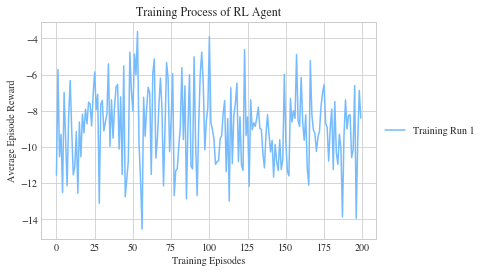

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
 
x = list(range(episodes_per_day))
y1 = av_list1
#y2 = av_list2

fig = plt.figure(1)

plt.plot(x, y1, 'xkcd:sky blue', label = "Training Run 1") 
#plt.plot(x, y2, 'xkcd:steel blue', label = "Training Run 2")
    
# naming the x axis 
plt.xlabel('Training Episodes') 
# naming the y axis 
plt.ylabel('Average Episode Reward') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

header = "Training Process of RL Agent"
plt.title(header) 
    
filename = header + ".png"
#plt.savefig(filename, dpi=300)
fig.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename) 

# function to show the plot 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

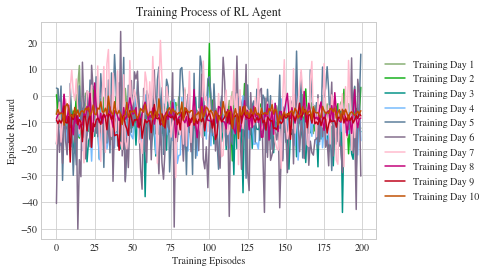

In [33]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
 
x = list(range(episodes_per_day))
y1 = episode_reward_list1
y2 = episode_reward_list2
y3 = episode_reward_list3
y4 = episode_reward_list4
y5 = episode_reward_list5
y6 = episode_reward_list6
y7 = episode_reward_list7
y8 = episode_reward_list8
y9 = episode_reward_list9
y10 = episode_reward_list10

fig = plt.figure(1)

plt.plot(x, y1, 'xkcd:sage', label = "Training Day 1") 
plt.plot(x, y2, 'xkcd:green', label = "Training Day 2")
plt.plot(x, y3, 'xkcd:teal', label = "Training Day 3")
plt.plot(x, y4, 'xkcd:sky blue', label = "Training Day 4") 
plt.plot(x, y5, 'xkcd:steel blue', label = "Training Day 5")
plt.plot(x, y6, 'xkcd:grey purple', label = "Training Day 6")
plt.plot(x, y7, 'xkcd:pastel pink', label = "Training Day 7") 
plt.plot(x, y8, 'xkcd:magenta', label = "Training Day 8")
plt.plot(x, y9, 'xkcd:scarlet', label = "Training Day 9")
plt.plot(x, y10, 'xkcd:burnt orange', label = "Training Day 10")
    
# naming the x axis 
plt.xlabel('Training Episodes') 
# naming the y axis 
plt.ylabel('Episode Reward') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

header = "Training Process of RL Agent"
plt.title(header) 
    
filename = header + ".png"
#plt.savefig(filename, dpi=300)
fig.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename) 

# function to show the plot 
plt.show()

In [ ]:
%tensorboard --logdir=~/ray_results

## Test

In [34]:
def get_config_Test(dic, Number_Days):  

    env_config = []

    for index in range(Number_Days):

      print(index)

      price_array, tech_array, turbulence_array = df_to_array(dic[index+Number_Train_Days], False)

      config = {
          "price_array": price_array,
          "tech_array": tech_array,
          "turbulence_array": turbulence_array,
          "if_train": False,
      }

      env_config.append(config)

    return env_config

In [35]:
test_env_config = get_config_Test(dic, Number_Test_Days)

0
Successfully transformed into array
1
Successfully transformed into array
2
Successfully transformed into array
3
Successfully transformed into array
4
Successfully transformed into array
5
Successfully transformed into array
6
Successfully transformed into array
7
Successfully transformed into array
8
Successfully transformed into array


In [43]:
def DRL_prediction(
            model_name,
            env,
            env_instance,
            price_array,
            tech_array,
            turbulence_array,
            agent_path,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_name == "a2c":
            model_config = MODELS[model_name].A2C_DEFAULT_CONFIG.copy()
        elif model_name == "td3":
            model_config = MODELS[model_name].TD3_DEFAULT_CONFIG.copy()
        else:
            model_config = MODELS[model_name].DEFAULT_CONFIG.copy()
        model_config["env"] = env
        model_config["log_level"] = "WARN"
        model_config["env_config"] = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        model_config['framework'] = "tf2"

        model_config["model"]["use_lstm"] = True
        model_config["model"]["lstm_cell_size"] = 256
        model_config["model"]["lstm_use_prev_action"] = True
        model_config["model"]["lstm_use_prev_reward"] = True

        env_config = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        env_instance = env(config=env_config)

        # ray.init() # Other Ray APIs will not work until `ray.init()` is called.
        if model_name == "ppo":
            trainer = MODELS[model_name].PPOTrainer(env=env, config=model_config)
        elif model_name == "a2c":
            trainer = MODELS[model_name].A2CTrainer(env=env, config=model_config)
        elif model_name == "ddpg":
            trainer = MODELS[model_name].DDPGTrainer(env=env, config=model_config)
        elif model_name == "td3":
            trainer = MODELS[model_name].TD3Trainer(env=env, config=model_config)
        elif model_name == "sac":
            trainer = MODELS[model_name].SACTrainer(env=env, config=model_config)

        print('got trainer')
        
        #try:
         #   trainer.restore(agent_path)
          #  print("Restoring from checkpoint path", agent_path)
        #except BaseException:
         #   raise ValueError("Fail to load agent!")
        
        trainer.restore(agent_path)
        print("restored agent")
        print("Restoring from checkpoint path", agent_path)

        # test on the testing env
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [env_instance.initial_total_asset]
        obs = env_instance.reset()
        state = [np.zeros([256], np.float32) for _ in range(2)]
        prev_a = 0
        prev_r = 0.0
        done = False
        total_reward = 0.0

        print("starting the loop")

        while not done:
            action, state, _ = trainer.compute_single_action(obs, state, prev_action=prev_a, prev_reward=prev_r)
            obs, reward, done = env_instance.step(action)

            prev_a = action
            prev_r = reward

            total_reward += reward

            total_asset = (
                    env_instance.amount
                    + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        ray.shutdown()
        print("episode return: " + str(episode_return))
        print("Test Finished!")
        return episode_total_assets

In [39]:
def DRL_prediction(
            model_name,
            env,
            env_instance,
            price_array,
            tech_array,
            turbulence_array,
            agent_path,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_name == "a2c":
            model_config = MODELS[model_name].A2C_DEFAULT_CONFIG.copy()
        elif model_name == "td3":
            model_config = MODELS[model_name].TD3_DEFAULT_CONFIG.copy()
        else:
            model_config = MODELS[model_name].DEFAULT_CONFIG.copy()
        model_config["env"] = env
        model_config["log_level"] = "WARN"
        model_config["env_config"] = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }

        #model_config["model"]["use_lstm"] = True
        #model_config["model"]["lstm_cell_size"] = 256
        #model_config["model"]["lstm_use_prev_action"] = True
        #model_config["model"]["lstm_use_prev_reward"] = True

        env_config = {
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_train": False,
        }
        #env_instance = env(config=env_config)

        # ray.init() # Other Ray APIs will not work until `ray.init()` is called.
        if model_name == "ppo":
            trainer = MODELS[model_name].PPOTrainer(env=env, config=model_config)
        elif model_name == "a2c":
            trainer = MODELS[model_name].A2CTrainer(env=env, config=model_config)
        elif model_name == "ddpg":
            trainer = MODELS[model_name].DDPGTrainer(env=env, config=model_config)
        elif model_name == "td3":
            trainer = MODELS[model_name].TD3Trainer(env=env, config=model_config)
        elif model_name == "sac":
            trainer = MODELS[model_name].SACTrainer(env=env, config=model_config)

        print('got trainer')
        
        #try:
         #   trainer.restore(agent_path)
          #  print("Restoring from checkpoint path", agent_path)
        #except BaseException:
         #   raise ValueError("Fail to load agent!")
        
        trainer.restore(agent_path)
        print("restored agent")
        print("Restoring from checkpoint path", agent_path)

        state = env_instance.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [env_instance.initial_total_asset]
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)

            total_asset = (
                    env_instance.amount
                    + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        ray.shutdown()
        print("episode return: " + str(episode_return))
        print("Test Finished!")
        return episode_total_assets

In [37]:
def test(
        env_config,
        env,
        capital,
        model_name,
        cwd,
        if_vix=True,
        **kwargs
):

    env_instance = env(config=env_config, initial_capital=capital)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    #cwd = "./trained_" + str(model_name)

    print("price_array: ", len(env_config["price_array"]))

        # load agent
    
    #episode_capital = [capital]
    episode_total_assets = DRL_prediction(
            model_name=model_name,
            env=env,
            env_instance = env_instance,
            price_array=env_config["price_array"],
            tech_array=env_config["tech_array"],
            turbulence_array=env_config["turbulence_array"],
            agent_path=cwd,
        )
    account_value = episode_total_assets

    return account_value



In [44]:
ray.shutdown()

In [45]:
test_results = []
starting_capital = 10e6
final_capital = [starting_capital]

for index in range(len(test_env_config)):

      print(index)

      account_value = test(env_config = test_env_config[index],
                      env=env, 
                      capital = final_capital[index], 
                      model_name=model_algorithm,
                      cwd =  checkpoint_path,
                      net_dimension = 512)
      final_capital.append(account_value[-1])
      ray.shutdown()
      test_results.append(account_value)
print(final_capital)
      

0
price_array:  481


2022-05-17 14:35:10,794	INFO services.py:1462 -- View the Ray dashboard at http://127.0.0.1:8265
(RolloutWorker pid=243740) 2022-05-17 14:35:32,214	WARNING rollout_worker.py:499 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=243740) 2022-05-17 14:35:32,214	WARNING env.py:121 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=243869) 2022-05-17 14:35:41,578	WARNING rollout_worker.py:499 -- We've added a module for checking environments that a

2022-05-17 14:36:10,721	INFO trainable.py:156 -- Trainable.setup took 64.147 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


got trainer


2022-05-17 14:36:13,746	INFO trainable.py:535 -- Restored on 172.28.0.2 from checkpoint: /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
2022-05-17 14:36:14,160	INFO trainable.py:543 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': 960000, '_time_total': 25935.713969230652, '_episodes_total': 2000}
2022-05-17 14:36:14,297	ERROR tf_run_builder.py:52 -- Error fetching: [<tf.Tensor 'default_policy/cond_1/Merge:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'default_policy/model_1/lstm/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'default_policy/model_1/lstm/while/Exit_4:0' shape=(?, 256) dtype=float32>, {'action_prob': <tf.Tensor 'default_policy/Exp_1:0' shape=(?,) dtype=float32>, 'action_logp': <tf.Tensor 'default_policy/cond_2/Merge:0' shape=(?,) dtype=float32>, 'action_dist_inputs': <tf.Tensor 'default_policy/Reshape_3:0' shape=(?, 2) dtype=float32>, 'vf_preds': <tf.Tensor 'default_policy/Reshape_4:0' shape=(?,) dtype=float32>}], feed_dict={<tf.Te

restored agent
Restoring from checkpoint path /tmp/rllib_checkpoint/checkpoint_000010/checkpoint-10
starting the loop


ValueError: ignored

In [69]:
for index in range(len(test_results)):

  df_account_test = pd.DataFrame(data=test_results[index],columns=['account_value'])
  file_name = "A5 test "+str(index+1)+".csv"
  df_account_test.to_csv(file_name)
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>